# CS918 : Natural Language Processing
# Assignment 2
# u1729346

## Importing Libraries and the Data

Note: dev-data is used for cross-validation in LSTM 

In [31]:
import json
import re
import math
import nltk
import os
import pandas as pd
from nltk.corpus import stopwords as StopwordsLoader
from nltk.tokenize.casual import TweetTokenizer
import numpy as np
import matplotlib.pyplot as plt

nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

DEV_LOCATION = os.path.join("semeval-tweets","twitter-dev-data.txt")
TRAIN_LOCATION = os.path.join("semeval-tweets","twitter-training-data.txt")

[nltk_data] Downloading package wordnet to /Users/MT/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/MT/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
# Read the data into a pandas DataFrame
with open(DEV_LOCATION) as p:
    dev = pd.read_csv(p, sep="\t", names=["id", "sentiment", "tweet"])
with open(TRAIN_LOCATION) as n:
    train = pd.read_csv(n, sep="\t", names=["id", "sentiment", "tweet"])

Get a barplot of the target variable

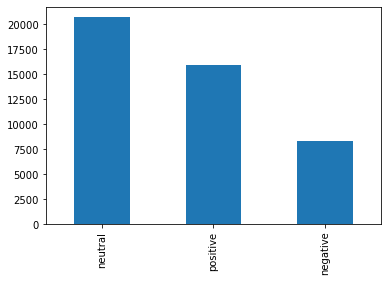

In [159]:
train['sentiment'].value_counts().plot(kind='bar')

## Text Pre-Processing
Removing all numeric words, single letter words, @mentions and non-alphanumeric characters except spaces. Hashtags are not removed completely because they often contain some information.

In [63]:
# Removal of non-alphanumeric characters except spaces, @s, #s and emojis: 
        # ([.,\!$%\^&\*\(\)=\-_`~\+\{\}<>\?:;\'\"\[\]\|]"))
# Removal of URLs ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
# Removal of single letter words: (\b\w\b)

def pre_process_data(data):    
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    an_pattern = re.compile(r"[.,\!$%\^&\*\(\)=\-_`~\+\{\}<>\?:;\'\"\[\]\|]")
    sl_pattern = re.compile(r"(\b\w\b)")
    update_dict = dict()
    count = 1
    total = data.shape[0]
    
    for tweet in data['tweet']:
        print(str(round((count/total)*100)) + "%", end='\r')
        count += 1
        update = url_pattern.sub(" ", tweet)
        update = an_pattern.sub("", update)
        update = sl_pattern.sub("", update)
        update = update.replace("/", " ")
        update = update.replace("\\", "")
        update_dict[tweet] = update.lower()
        
    data['tweet'] = data['tweet'].map(update_dict.get)
    # Inefficient  
#    data.replace({'tweet':update_dict})    

    return data

## Tokenization and Lemmatization
TweetTokenizer works the same as word_tokenize, but allows us to keep @mention's and #hashtags intact (as one token) and tokenize emoji's individually, which will be useful.

In [34]:
def tokenize_data(data):
    text_tokens = []
    tt = TweetTokenizer()
    count = 1
    total = data.shape[0]

    for text in data['tweet']:
        print(str(round((count/total)*100)) + "%", end='\r')
        count += 1
        text_tokens.append(tt.tokenize(text))
    
    return text_tokens

lemmatize_sentence removes stop words from tokenized representations and then lemmatizes the rest of the tokens

In [35]:
def lemmatize_data(data, lm, stop_words):
    lemmatized_sentences = []
    count = 1
    total = data.shape[0]

    for tokens in data['text_tokens']:
        print(str(round((count/total)*100)) + "%", end='\r')
        count += 1
        lemmatized_sentences.append(lemmatize_sentence(tokens, lm, stop_words))
    
    return lemmatized_sentences

def lemmatize_sentence(tokens, lm, stop_words):
    lemmatized_sentence = []
    
    for word, tag in nltk.tag.pos_tag(tokens):
        if word.lower() in stop_words:
            continue
        if tag.startswith('N'):
            pos = nltk.corpus.wordnet.NOUN
        elif tag.startswith('V'):
            pos = nltk.corpus.wordnet.VERB
        else:
            pos = nltk.corpus.wordnet.ADJ
        
        update = lm.lemmatize(word, pos)
        lemmatized_sentence.append(update)

    return lemmatized_sentence

Combining previous methods

In [36]:
def clean_tweets(data, lemmatize=True):
    print("Cleaning Tweets... ")
    data.update(pre_process_data(data))
    print("Tokenizing Tweets... ")
    data["text_tokens"] = tokenize_data(data)
    
    if lemmatize:
        lm = nltk.stem.WordNetLemmatizer()
        stop_words = StopwordsLoader.words("English")
        print("Lemmatizing Tweets... ")   
        data["text_tokens"].update(lemmatize_data(data, lm, stop_words))

    print("Complete.\n")  
    return data

Cleaning Tweets... 
Tokenizing Tweets... 
Lemmatizing Tweets... 
Complete.

Cleaning Tweets... 
Tokenizing Tweets... 
Lemmatizing Tweets... 
Complete.



In [65]:
dev.update(clean_tweets(dev))
train.update(clean_tweets(train))
train.shape, dev.shape

((45026, 4), (2000, 4))

## Visualising the Extracted Tokens

[('tomorrow', 5789), ('may', 5507), ('go', 4894), ('get', 3720), ('day', 3545), ('see', 2955), ('im', 2819), ('like', 2531), ('night', 2513), ('time', 2303), ('1st', 2163), ('sunday', 2127), ('friday', 2073), ('make', 2034), ('watch', 1976), ('come', 1961), ('one', 1934), ('say', 1934), ('good', 1931), ('new', 1703)]


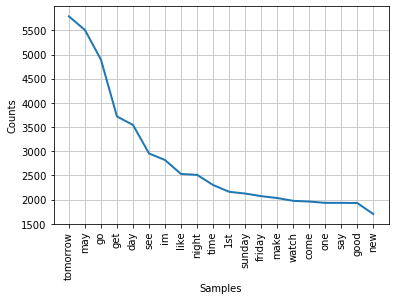

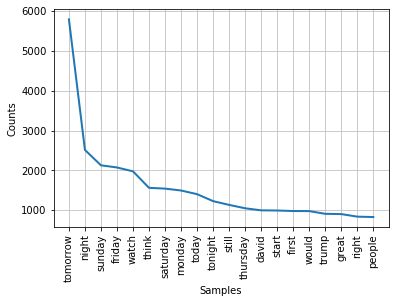

In [8]:
def plot_most_common(data):
    %matplotlib inline
    all_words = []

    for tokens_list in data['text_tokens']:
        for token in tokens_list:
            all_words.append(token)

    all_freq_dist = nltk.FreqDist(all_words)
    print(all_freq_dist.most_common(20))
    all_freq_dist.plot(20, cumulative=False, label="20 Most Common Words")

    long_freq_dist = nltk.FreqDist([x for x in all_words if (len(x) > 4)])
    long_freq_dist.plot(20, cumulative=False, label="20 Most Common Words (Longer than 4 Letters)")

plot_most_common(train)

## Constructing a Naive Bayes Classifier
NLTK Naive Bayes Classifier needs the tokens to be in a dictionary indicating the presence of those tokens



In [49]:
import random

def init_dict(tokens_data):
    for tokens_list in tokens_data:
        yield dict([token, True] for token in tokens_list)

def get_tweets_dict(data):
    ret = []
    tweets_dict = init_dict(data['text_tokens'])
    i = -1
    for tweets in tweets_dict:
        i+=1
        ret.append((tweets, data['sentiment'][i]))
    return ret

def train_bayes_classifier(train_data):
    train_dict = get_tweets_dict(train_data)
    return nltk.NaiveBayesClassifier.train(train_dict)

def get_bayes_predictions(classifier, test_data):
    n# Get predictions in desired dictionary format
    predictions ={}
    test_dict = get_tweets_dict(test_data)
    
    for index in range(len(test_data)):
        tweetid = str(test_data['id'][index])
        prediction = classifier.classify(test_dict[index][0])
        predictions[tweetid] = prediction
        
    return predictions


bayes_classifier = train_bayes_classifier(train)

## Testing using testsets.py and evaluation.py

In [147]:
from evaluation import evaluate, confusion
import testsets

for testset in testsets.testsets:
    TEST_LOCATION = os.path.join("semeval-tweets",testset)
    with open(TEST_LOCATION) as k:
        test = pd.read_csv(k, sep="\t", names=["id", "sentiment", "tweet"])
    test.update(clean_tweets(test))

    predictions = get_bayes_predictions(bayes_classifier, test)
    evaluate(predictions, TEST_LOCATION, "Naive Bayes Classifier")
    confusion(predictions, TEST_LOCATION, "Naive Bayes Classifier")

Cleaning Tweets... 
Tokenizing Tweets... 
Lemmatizing Tweets... 
Complete.

semeval-tweets/twitter-test1.txt (Naive Bayes Classifier): 0.542
            positive  negative  neutral
positive    0.484     0.084     0.432     
negative    0.179     0.434     0.387     
neutral     0.385     0.157     0.458     

Cleaning Tweets... 
Tokenizing Tweets... 
Lemmatizing Tweets... 
Complete.

semeval-tweets/twitter-test2.txt (Naive Bayes Classifier): 0.547
            positive  negative  neutral
positive    0.570     0.068     0.362     
negative    0.271     0.394     0.335     
neutral     0.524     0.088     0.388     

Cleaning Tweets... 
Tokenizing Tweets... 
Lemmatizing Tweets... 
Complete.

semeval-tweets/twitter-test3.txt (Naive Bayes Classifier): 0.517
            positive  negative  neutral
positive    0.518     0.077     0.406     
negative    0.237     0.332     0.430     
neutral     0.404     0.179     0.417     



# Constructing a RNN with LSTM and GloVe embedding

In [107]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Embedding, Activation
from keras.c import Tokenizer
from keras.optimizers import RMSprop, Adam

## Pre-Processing for Deep Learning

Removing all @mentions, #hashtags and non-alphanumeric characters

In [68]:
def remove_all_non_alphanumeric(data):
    print("Removing Non-Alphanumeric Characters...")
    pattern_mentions_hashtags = re.compile(r'([@#0-9][\w]+)')
    pattern_other = re.compile(r'[^a-zA-Z\s]')
    
    update_dict = dict()
    count = 1
    total = data.shape[0]

    for tweet in data['tweet']:
        print(str(round((count/total)*100)) + "%", end='\r')
        count += 1
        update = pattern_mentions_hashtags.sub("", tweet)
        update = pattern_other.sub("", update)
        update_dict[tweet] = update
        
    data['tweet'] = data['tweet'].map(update_dict.get)
    print("Complete.")
    return data

lstm_train = train
lstm_dev = dev
lstm_train.update(remove_all_non_alphanumeric(lstm_train))
lstm_dev.update(remove_all_non_alphanumeric(lstm_dev))

Removing Non-Alphanumeric Characters...
Complete.
Removing Non-Alphanumeric Characters...
Complete.


## Creating an Embedding Matrix

Obtain training and test data for keras

In [150]:
def get_tweets_for_LSTM_training(data):
    X = list(data['tweet'])
    y = pd.get_dummies(data['sentiment'], dtype='float32').values

    tk = Tokenizer(num_words=5000, oov_token='<OOV>')
    tk.fit_on_texts(X)
    X = tk.texts_to_sequences(X)
    
    max_words = len(tk.word_index) + 1
    
    X = pad_sequences(X, padding='post', maxlen=93)
    
    return X, y, max_words, tk

def get_tweets_for_LSTM_test(data, tk):
    X = list(data['tweet'])
    y = pd.get_dummies(data['sentiment'], dtype='float32').values
    
    X = tk.texts_to_sequences(X)
    X = pad_sequences(X, padding='post', maxlen=93)
    
    return X, y

In [151]:
X_train, y_train, max_words, tokenizer = get_tweets_for_LSTM_training(lstm_train)
X_dev, y_dev = get_tweets_for_LSTM_test(lstm_dev, tokenizer)

Map words to their vector representation

In [88]:
embeddings_dict = dict()
embedding_dim = 100

GLOVE_LOCATION = os.path.join("data","glove.6B.100d.txt")
glove_file = open(GLOVE_LOCATION, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    coefs = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = coefs
    
glove_file.close()

Create Embedding Matrix

In [148]:
def get_embedding_matrix(embeddings_dict, max_words, embedding_dim):
    embedding_matrix = np.zeros((max_words, embedding_dim))

    for word, index in tk.word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector    

    return embedding_matrix

embedding_matrix = get_embedding_matrix(embeddings_dict, max_words, embedding_dim)

39796 10125


Fitting a sequential model

In [152]:
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=93 , trainable=False)

LSTM_model = Sequential()

LSTM_model.add(embedding_layer)
LSTM_model.add(LSTM(100))
LSTM_model.add(Dense(3, activation='softmax'))

opt = RMSprop(learning_rate=0.01)
LSTM_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(LSTM_model.summary())

history = LSTM_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data=(X_dev, y_dev))

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 93, 100)           3979600   
_________________________________________________________________
lstm_40 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 303       
Total params: 4,060,303
Trainable params: 80,703
Non-trainable params: 3,979,600
_________________________________________________________________
None
Epoch 1/5
352/352 [==============================] - 75s 213ms/step - loss: 1.0514 - accuracy: 0.4588 - val_loss: 1.0404 - val_accuracy: 0.4595
Epoch 2/5
352/352 [==============================] - 69s 195ms/step - loss: 1.0375 - accuracy: 0.4606 - val_loss: 1.0398 - val_accuracy: 0.4595
Epoch 3/5
352/352 [==============================] - 67s 190ms/step - loss:

## Testing using testsets.py and evaluation.py

In [155]:
from evaluation import evaluate, confusion
import testsets

classes = ['negative', 'neutral', 'positive']
predictions = {}

for testset in testsets.testsets:
    TEST_LOCATION = os.path.join("semeval-tweets",testset)
    
    with open(TEST_LOCATION) as k:
        test = pd.read_csv(k, sep="\t", names=["id", "sentiment", "tweet"])
    
    test.update(clean_tweets(test, lemmatize=False))  
    
    X_test, y_test = get_tweets_for_LSTM_test(test, tk)
    prediction = LSTM_model.predict(X_test)
    
    for index in range(len(y_test)):
        tweetid = str(test['id'][index])
        j = np.argmax(prediction[index])
        predictions[tweetid] = classes[j]
    
    confusion(predictions, TEST_LOCATION, "LSTM")
    evaluate(predictions, TEST_LOCATION, "LSTM")
    score = LSTM_model.evaluate(X_test, y_test)
    print('Test set\n  Score:', score[0], '\n  Accuracy:', score[1])

Cleaning Tweets... 
Tokenizing Tweets... 
Complete.

            positive  negative  neutral
positive    0.000     0.000     0.000     
negative    0.000     0.000     0.000     
neutral     0.416     0.158     0.426     

semeval-tweets/twitter-test1.txt (LSTM): 0.000
111/111 [==============================] - 2s 20ms/step - loss: 1.0308 - accuracy: 0.4259
Test set
  Score: 1.0308107137680054 
  Accuracy: 0.4259416460990906
Cleaning Tweets... 
Tokenizing Tweets... 
Complete.

            positive  negative  neutral
positive    0.000     0.000     0.000     
negative    0.000     0.000     0.000     
neutral     0.530     0.109     0.361     

semeval-tweets/twitter-test2.txt (LSTM): 0.000
58/58 [==============================] - 1s 22ms/step - loss: 1.0191 - accuracy: 0.3610
Test set
  Score: 1.0191476345062256 
  Accuracy: 0.36103615164756775
Cleaning Tweets... 
Tokenizing Tweets... 
Complete.

            positive  negative  neutral
positive    0.000     0.000     0.000     
negativ

## LSTM with dropout and Adam Optimizer

In [156]:
LSTM_model2 = Sequential()

LSTM_model2.add(embedding_layer)
LSTM_model2.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
LSTM_model2.add(Flatten())
LSTM_model2.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
LSTM_model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(LSTM_model2.summary())

history2 = LSTM_model2.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_dev, y_dev))

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 93, 100)           3979600   
_________________________________________________________________
lstm_41 (LSTM)               (None, 93, 64)            42240     
_________________________________________________________________
flatten_26 (Flatten)         (None, 5952)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 3)                 17859     
Total params: 4,039,699
Trainable params: 60,099
Non-trainable params: 3,979,600
_________________________________________________________________
None
Epoch 1/10
352/352 [==============================] - 71s 201ms/step - loss: 0.8510 - accuracy: 0.5949 - val_loss: 0.8038 - val_accuracy: 0.6225
Epoch 2/10
352/352 [==============================] - 80s 227ms/step - loss: 0.7839 - 

## Testing using testsets.py and evaluation.py

In [157]:
from evaluation import evaluate, confusion
import testsets

classes = ['negative', 'neutral', 'positive']
predictions = {}

for testset in testsets.testsets:
    TEST_LOCATION = os.path.join("semeval-tweets",testset)
    
    with open(TEST_LOCATION) as k:
        test = pd.read_csv(k, sep="\t", names=["id", "sentiment", "tweet"])
    
    test.update(clean_tweets(test, lemmatize=False))  
    
    X_test, y_test = get_tweets_for_LSTM_test(test, tk)
    prediction = LSTM_model2.predict(X_test)
    
    for index in range(len(y_test)):
        tweetid = str(test['id'][index])
        j = np.argmax(prediction[index])
        predictions[tweetid] = classes[j]
    
    confusion(predictions, TEST_LOCATION, "LSTM2")
    evaluate(predictions, TEST_LOCATION, "LSTM2")
    score = LSTM_model2.evaluate(X_test, y_test)
    print('Test set\n  Score:', score[0], '\n  Accuracy:', score[1])

Cleaning Tweets... 
Tokenizing Tweets... 
Complete.

            positive  negative  neutral
positive    0.721     0.061     0.218     
negative    0.212     0.549     0.239     
neutral     0.284     0.146     0.570     

semeval-tweets/twitter-test1.txt (LSTM2): 0.520
111/111 [==============================] - 2s 20ms/step - loss: 0.8563 - accuracy: 0.6304
Test set
  Score: 0.8562581539154053 
  Accuracy: 0.6304163336753845
Cleaning Tweets... 
Tokenizing Tweets... 
Complete.

            positive  negative  neutral
positive    0.760     0.043     0.197     
negative    0.213     0.583     0.204     
neutral     0.396     0.106     0.498     

semeval-tweets/twitter-test2.txt (LSTM2): 0.529
58/58 [==============================] - 1s 20ms/step - loss: 0.8454 - accuracy: 0.6325
Test set
  Score: 0.8453859090805054 
  Accuracy: 0.6324878334999084
Cleaning Tweets... 
Tokenizing Tweets... 
Complete.

            positive  negative  neutral
positive    0.722     0.067     0.212     
negati

Plots to diagnose model

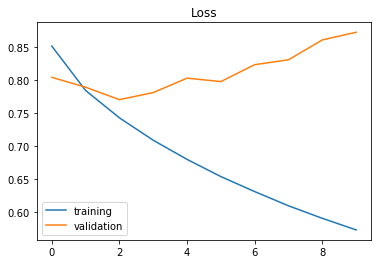

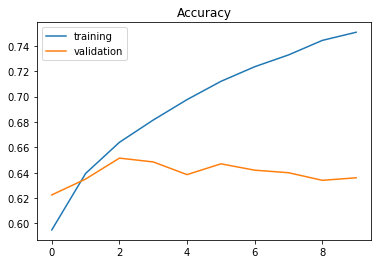

In [158]:
plt.title('Loss')
plt.plot(history2.history['loss'], label='training')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='training')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.show()